In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch

In [4]:
use_cuda = torch.cuda.is_available()

In [5]:
import numpy as np

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from stackRNN import StackAugmentedRNN
from predictor import RandomForestQSAR
from data import GeneratorData
from data import PredictorData
from data import sanitize_smiles
from data import cross_validation_split
from reinforcement import Reinforcement
from ReplayMemory import ReplayMemory

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
gen_data_path = '/data/masha/generative_model/chembl_22_clean_1576904_sorted_std_final.smi'
logp_data_path = '/home/mariewelt/Notebooks/gan_oracle/oracle_data/logP_labels.csv'

In [8]:
gen_data = GeneratorData(training_data_path=gen_data_path, use_cuda=use_cuda)

In [9]:
logp_data = PredictorData(path=logp_data_path, use_cuda=use_cuda, cols=[1, 2])

In [10]:
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']
char2idx = {}
gen_data.load_dictionary(tokens, char2idx)

In [11]:
hidden_size = 500
stack_width = 100
stack_depth = 100
lr = 0.01

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, stack_width=stack_width,
                                 stack_depth=stack_depth, use_cuda=use_cuda, n_layers=1,
                                 optimizer='Adadelta', lr=lr)

if use_cuda:
    my_generator = my_generator.cuda()

In [12]:
my_generator.load_model('/home/mariewelt/Notebooks/PyTorch/Model_checkpoints/generator/checkpoint_lstm')

In [13]:
logp_predictor = RandomForestQSAR(model_type='regressor', n_estimators=100, n_ensemble=5)

In [14]:
logp_predictor.load_model('/home/mariewelt/Notebooks/PyTorch/Model_checkpoints/logP/')

In [ ]:
#cross_val_data, cross_val_labels = cross_validation_split(logp_data.smiles, logp_data.property)
#cv_metric, metric_type = logp_predictor.fit_model(PredictorData, cross_val_data, cross_val_labels)
#logp_predictor.save_model('/home/mariewelt/Notebooks/PyTorch/Model_checkpoints/logP/')

In [15]:
RL = Reinforcement(my_generator, logp_predictor)
replay = ReplayMemory(capacity=15000)

In [16]:
for i in range(len(logp_data.smiles)):
    replay.push('<' + logp_data.smiles[i] + '>')

In [ ]:
generated = []
for _ in range(10000):
    generated.append(my_generator.evaluate(gen_data)[1:-1])

In [23]:
sanitized_unbiased = list(np.unique(sanitize_smiles(generated))[1:])

/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: CC(CCC=CC(C)=CC(=O)OC1C(C)(C)C2CCC3C(CCC4C(O)C(O)CCCC34C)C12
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)c1ccc(cc1)-c1nc(CN2CCCC2)c2nccn12
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)(F)c1ccc(NC(=O)N2CCC3(CC2COc4c-c2c4OCOc2c34)c2cccnc2)cc1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: CC(C)C1NC(Cc2ccc(O)c(COc3cccc(c3)C(F)(F)F)c2)CN1C(=O)C(Cc1ccc(OCc2ccccc2)N2CCOCC2)n1N
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1ccc(Oc2cc(Oc3ccnc4c

/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: C3CCCNC1=NC(=O)c2c(N1)sc1CCCCc21
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: OC(CCCCc1ccc(Oc2ccc(CCCC3=C(CCc4ccccc4)CCC3)Oc2)cc1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: O=C(CN1C(=O)C(Oc2ccc3ccccc23)=CC=C1c1ccccc1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)(F)c1cccc(NC(=O)c2c(cc3ccccc23)N(=O)=O)c1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(CCCCCCCCC(=O)N1CCOCC1)COc1cccc2Cl
  warnings.warn('Unsanitized SMILES string: ' + sm, UserW

/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)(F)c1ccn2ncnc(Nc3cc(nc4ccccc4c3)C(=O)N3CC3)c2c1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)(F)c1cc(Cl)c(NC(=O)Cn2nnc(c2C3=O)N(Cc2ccccc2)C(=O)c2ccccc2)c(Cl)c1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1ccc(NC(=O)NCc2ccc(cc2)-c2cc(-c3n[nH]c(n3)-c3ccccc3)n(CC=C)c2CCc2ccccc2Cl)n1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)c1cccc2C(=NN(Cc3cccnc3)N(=O)C3CCOC3)C(=O)c2c1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: CN(C1CCN(C1)C(=

/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: COc1cc(OCC(O)CNCCc2ccccc2)c2ccc(OCCCN3CCC(C)C(C3)NC(=O)c3ccClcc4nscc34)c2c1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1ccc(NC(=O)c2nnc(CCCCCNCCc3ccccc3)n3c2cc2oc3cc4[nH]c(Cl)cc4cc2ccc2ccc(Cl)cc4nc32)cc1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)(F)c1cccc(CN2C(=O)N(C3OC(=O)N(C3=O)c3ccccc3)c3ccc4cccc1c24
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: O=C(NCCCCCCCN1CCN(CC1)C1CCC1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: N#CCN1CCC23C2N

/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: ONC(=N)C(CCCCNC(=O)c1ccccc1OCc1ccccc1Br)NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(O)O1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1ccc(COc2cc(cc(F)c2)-c2nc(SCc3ccccn3)nn2CCc2ccccc2
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: O=S(NC(=O)c1ccc2SCC(=Nc2c1)c1cccc(c1)N(=O)=O
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: CN(C1CCN(CC1)c1ccc(nc1)C(=O)N1CCCC(C1)N1CCCC1=O
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1cc(Cl)c2CN3CCC(N3c3ccc(Nc4nc(Ncnc

/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: CC1CCC2CC(NC(=O)Cc3ccc(OCC(=O)Nc4cc(OCCN(CC(O)=O)cn4)C2)cc3)CC1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1ccc(cc1)C(=O)Nc1nc2ccccc2c2cnnc12
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Clc1ccc2c(CCNC(=O)c3ccc(cc3)-c3ccc(NC(=O)c4ccc(NC=CC(=O)Nc4ccc(cc4)C(F)(F)F)cc3)cn2)c1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1ccc(cc1)-c1cc(nc(NCC=C)n1-c1ccc(F)cc1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: CCCCOC(=O)C(=CN(C1CCCC1)C(=O)CCc1nnc(CCCC

/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: CC)C=NNc1ccc(cc1)1N=C(CC1(O)c1ccccc1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: COC(=O)c1ccc2n(CCCN3CCC(Cc4ccccc4)CC3)c3c(c4c4cc(C)c(OC)c(O)c4c(cn3C)C(=O)N3CCC(CC3)c3ncccc3Cl)c2c1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: COc1cc(cc(OC)c1OCCCOc1ccccc1CCCNS(=O)(=O)c1ccc(C)cc1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1cccc(c1)-c1cn(CCCO)c2nc3c(Cl)cccc3nc2c1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: OCC(COC(=O)N1CC(COC2Cn3c(nc(c3C2)C(O)

In [22]:
smiles_unbiased, prediction_unbiased, nan_smiles = logp_predictor.predict(sanitized)

2.661147926988487
0.6658
0.6109942925803544


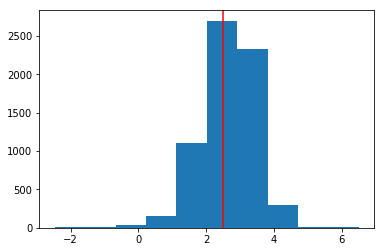

In [24]:
print(prediction.mean())
print(len(sanitized_unbiased)/10000)
print(len(np.where(prediction_unbiased >= 2.5)[0])/len(prediction_unbiased))
plt.hist(prediction_unbiased)
plt.axvline(x=2.5, color='red')
plt.show()

In [26]:
for i in range(len(prediction_unbiased)):
    if prediction_unbiased[i] < 0:
        print(smiles_unbiased[i])

C#CCN1CCN(C(=O)C2CC3CCC(=O)N32)CC1
CC(C)C(NC(=O)N1CC(O)CO1)C(=O)NN=C1CCCCC1
CC(C)CC(NC(=O)N1CCC(N2Cc3c(C(=O)N4CCCC4)nc(n3CCC(N)C(F)(F)F)C2O)CC1)C(=O)O
CC(C)N(C(=O)Cn1cnc2c(N)ncnc21)C(CCSCC(=O)O)C(=O)O
CC1CC(O)C(O)C2C(=O)N(N)C(=O)C12
CC1CCCC(NCC(O)CON=C(C(N)=O)C2CCC3CC(=O)N(CC(=O)O)CC32)CC1
CCC1OC(OC)C(O)C1OCn1ncc2c(N)ncnc21
CCCCC(CC1CC1)N1C(=O)C(=O)NC2(CCCCC2)C(O)C1C
CCCCCCCCCCC1NC(=O)C(CCCCN)NC(=O)c2c(C)c(C(C)=O)nn2C(=O)C(N)C1C
CCCCCCCCCCCCCC1CCC(=O)C1CC(=O)NC(CCCN=C(N)N)C(=O)NC(CC(=O)O)C(=O)N1CCCC1C(=O)O
CCCCCCCCCCCCCCCCCC(=O)CCCC[N+](CCC)(CCCCC)CCCCCCC
CCCCCCCCCCCCCCCCCC(=O)NC(CCCCN)C(=O)O
CCCCCCCCCCCCCCCCCCCCC(=O)NC(COC1OC(CO)C(O)C(O)C1O)C(O)C(O)CCCCCCCCCCCNC(=O)CCCCCCCCCNC(=O)CCCCCCCN
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(N)C(=O)NC(CC(C)C)C(=O)O
CCCCCCCCCCCCOC(COC(N)=O)C(=O)O
CCCCN(CCC)C(=O)CN1CCCN(C)C1=O
CCCCSCC(C(=O)N1CCCC1C(=O)NC(Cc1ccccc1)C(=O)NCC(=O)O)C(C)C
CCCNC(CCC(=O)O)C(=O)O
CCN(CC(=O)NC(C)c1ncccn1)C(=O)N1CCOCC1
CCOC(=O)N1CCN(c2nc(C)c3ncn(C4OC(CO)C(O)C4O)c3n2)CC1
CCSCCC

In [27]:
transfer_pool = []
smiles, prediction, nan_smiles = logp_predictor.predict(sanitized_unbiased)
for i in np.where(prediction >=2.5)[0]:
    transfer_pool.append('<' + smiles[i] + '>')

In [28]:
f = open('/home/mariewelt/Notebooks/PyTorch/data/transfer_data.smi', 'w')
for sm in transfer_pool:
    f.writelines(sm + '\n')
f.close()

In [29]:
transfer_data = GeneratorData('/home/mariewelt/Notebooks/PyTorch/data/transfer_data.smi')
transfer_data.load_dictionary(tokens, char2idx)

In [31]:
for i in range(len(transfer_data.file)):
    replay.push(transfer_data.file[i])

 34s (100 20%) 1.0429]
<Fc1cc(OCC(=O)C2CCCN2Cc2ccc(F)cc2)ccc1C(=O)N1CCN(Cc2ccccc2)CC1> 

 8s (200 40%) 0.8819]
<FC(F)c1cccc(C(=O)N2CCC(Cc3cc(F)ccc3F)CC2C(=O)Nc2ccc(Cl)cc2Cl)c1> 

 42s (300 60%) 0.7472]
<O=CCNc1ccc(cc1C=Nc1cc(C-c2ccc(C(=O)N3CCC(F)(F)CC3)cc2)oc1C(=O)N1CCCC1)N1CCCCC1> 

 17s (400 80%) 0.7418]
<FC(F)(F)c1cccc(-c2cc(C(=O)N3CCN(Cc4ccccc4)CC3)n(-c3ccccc3)c2n1> 

 48s (500 100%) 0.4899]
<Fc1ccc(NC(=O)c2ccc(C3=NC(=O)NC(=O)c3c3CCCCC3)cc2Cl)cc1> 



/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)CN1CCN(Cc2cc(F)c(F)c(F)c2)CCc2cc(N3CCCCC3)c(-c3ccc(F)cc3)c12
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1ccc(-c2cc(C(=O)N3CCC(N(Cc4ccc(Cl)cc4)CC3)C(F)(F)F)C(=O)c3ccccc23)cc1Cl
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)CN1CC(c2c(F)cccc2F)C2CN(C(=O)c3ccccc3)C22C(c3cc4c(O)cccc4c3c3ccc(O)c=CC1CCC23C45)C(O)=O
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1cc(C=Cc2ccc(C(=O)N3CC4CC3C(N4CCNCCCc4c4[nH]c5ccccc5C4)C(F)(F)F)cc2)c(-c2ccc(F)cc2)c(C(F)(F)F)n1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorc

/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1ccc(cc1C(=O)N1CCC(Cc2ccc(-c3ccc(C(F)(F)F)cc3)n2)CC1)N1CCN(Cc2cccc(F)c2)CC1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: O=C(Nc1ccc(cc1)-c1ccc(nc1)-c1cccc(-c2ccc(-c3ccccc3)c(c2)N(=O)=O)N(=O)=O)n1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)c1cc(-c2ccc(CC(=O)NCCCN3CCC(CN4CCN(Cc5ccc(C(Cl)c5ccc5cccc(OC45)ccc1)C(F)(F)F)cc3)cc2)cccc1Cl
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1cc(OCC(F)(F)C2=CN(c3cc(Cl)cc(Cl)c3)CCCn2nc2cc(ccc12)N(=O)=O
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:1

3.188811464169525
0.502
0.8562874251497006


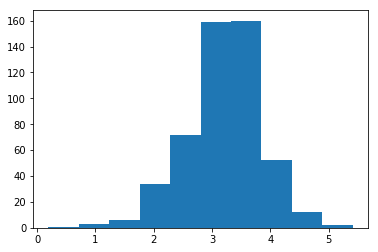

-1.8277654647827148
23.512271881103516
16.267271041870117
14.402153968811035
9.38942813873291
-2.2622997760772705
22.55758285522461
19.268924713134766
22.960668563842773
24.218978881835938
25.73870277404785
24.72510528564453
10.626557350158691
0.974953293800354
16.86147117614746
31.103445053100586
13.67840576171875
5.1665143966674805
17.10051918029785
4.594235897064209


/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: O=C(NCCc1ccc(N2CCCC2)cc1)c1cc(-c2ccc(c(-c3ccc(CN4CCCCC4)cc3)c3ccc(F)cc23)-c2ccc(F)cc2)ccc1Cl
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)(F)c1ccc(-c2ccc(C(=O)N3CCC(NC3=O))C(=O)c3ccc(F)cc3)c(C(=O)Nc3ccc(F)c(Cl)c3)c2nc1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)(F)c1cccc(c1)N1CCN(Cc2cc(F)c(cc2-N2C(=O)Nc3cnc(-c4ccc(F)cc4)cc23)C(=O)NC2CCCCC2)c2nc(Nc3ccc(F)
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)(F)c1ccc(Nc2nc(c(-c3ccc(F)cc3)c(C(F)(F)F)-c3cccc(Cl)c3)n2)cc1NC(=O)c1ccncc1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/hom

3.255748072467964
0.519
0.9036608863198459


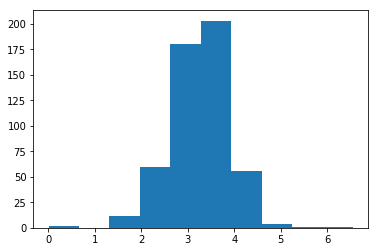

-1062.4144287109375
-1050.68798828125
-1065.1549072265625
-1038.808837890625
-1050.423095703125
-1067.4273681640625
-1024.7802734375
-1079.103759765625
-1066.56201171875
-1106.7242431640625


/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: O=C(N(Cc1ccc(Cl)cc1)NCc1ccc(cc1)N1CCN(Cc2ccc3c(Nc4nc(-c51)OC4CCNC4)ccc1nc1ccccc21)COC(=O)c1ccc(F)cc
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1cc(-c2(C1=O)c(CCCC23CCC(CC(O)=O)CCC1)c(-c2c(Cl)cccc2Cl)n(CC3CCCC3)c1Cl)N1CCCC1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1ccc(c(F)c1S(=O)(=O)NCCc1ccc2ccccc2c1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)(F)c1cccc(NC(=O)N2n3c(c(F)cc3-c3cnn(c3-c3cccc(-c4ccccc4S(=O)(=O)Nc4cccc(-c4ccc(Cl)cc4)C(F)(F)F
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/d

3.2004791686922713
0.468
0.8843683083511777


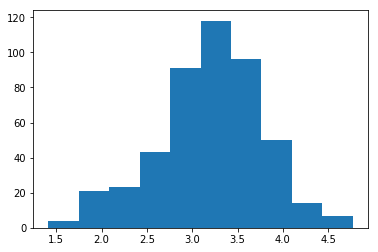

 19s (100 20%) 0.6781]
<FC(F)(F)c1ccc(NC2=CC3=NN(=C(S2)C(=O)NCc4ccc(Cl)cc4)Cl> 

 44s (200 40%) 0.3062]
<FC(F)(F)c1ccc(C(=O)ON2CCCC(C2)c2cccc(c2)C(=O)N2CCCN(Cc3ccc(F)c(F)c3)CC2)c(Cl)c1> 

 15s (300 60%) 0.5967]
<Fc1ccc(CN2C3=C(NC(=O)C[N+]([O-])=O)CCOc3cc(C(=O)C(F)(F)F)cc2N3CC(F)(F)CCCC(F)(F)F> 

 46s (400 80%) 0.6942]
<Fc1ccc(CN2CCC(C2)Nc2ccc(cn2)N2C(=O)NC3(SCCOC3=O)C(=O)N2Cc2ccccc2)cc1> 

 17s (500 100%) 0.4800]
<O=C(Nc1ccc(CCOc2ccc(cc2-c2cc(c(-c3ccccc3)c(-c3ccccc3)c3ccccc3)C(=O)N2)cc1)N1CCN(Cc2ccc(cc2)C(F)(F)F) 



/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1ccc(CC(=O)NNC(=O)CCNc2ccc3ncccc3c2C(=O)OCCN2CCN(Cc3ccc(NC(=O)c4cccc(Nc4ncn4cccc4F)-c4ccc(F)cc4)c
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)c1ccccc1CC(=O)Nc1ccc(Cl)c(Nc2nc3c(n[nH]c34)C3CCN(CC3)c3ccccn3)cc2c1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1cccc(C(=NNc2ccc(Oc3cccc(=C3)n2CCN2CCN(CC2)c2ccc(F)cc2)C1=O)c1ccc(Cl)cc1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1c(F)c(N2CCN(Cc3ccc(F)cc3)CC2)c(NC(=O)Cc2ccccc2)c(C(=O)Nc2ccc(Cl)c(c2)C(F)(F)F)c1Nc1ccnc2ccc(Cl)c
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/

/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)Oc1ccc(CN2CCC3(N(CCCNCCOc4ccc5ccc(O)c5c5)C(=O)C(F)(F)F)CCC4)ccc3c2C(=O)N(Cc2ccc(F)cc2)C1=O
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)(F)c1cccc(N2CCN(C(=O)C3CCCCC3)CCc2c1F)C(=O)c1ccc((F)F)cc1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1ccc(cc1)-c1noc(n1)-c1ccc(-c2ccc(F)cc2)c2c(c(-c3ccc(C(=O)Nc4nc(C(F)(F)F))N4)nnc3-c3ccc(F)cc3Cl)c(
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)c1cccc(NC(=O)CC2CCCN2S(=O)(=O)c2ccc3N(Cc4ccc(Cl)cc4)CC(=O)c3c2Clc1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch

3.153007911683471
0.541
0.8502772643253235


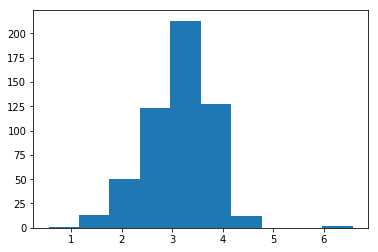

27.53348731994629
25.47686767578125
17.438247680664062
30.6601505279541
22.531757354736328
28.06450653076172
29.03299903869629
26.42251205444336
44.40489196777344
24.462804794311523
30.500322341918945
27.157609939575195
25.288434982299805
32.95127487182617
41.168582916259766
34.55567932128906
22.635971069335938
24.529987335205078
19.857709884643555
21.159101486206055


/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)(F)c1ccc(C(=O)N2CCN(Cc3cncc(c3)-c3nnc(-c4ccc(C(F)(F)F)c4)cc3)C2CC(N2CCCN(Cc3cccc(c3)C(F)C(F)(F
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)(F)c1cc(C(=O)Nc2ccc3snc(Nc4cccc5ccccc5c4)c[n+]3CCc2(cc2cccc(Cl)c2)C(F)(F)F)ncc1Cl
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FCC1CCN(Cc2cc(N3CCN(Cc4cccc(Cl)c4)c3nc4ccc(F)cc4)CCc3cc(F)ccc23)CC1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1cc(F)c(N2CCN(CC(=O)N3CCN(Cc4cccc(C(=O)N4CC4)CC3)CC2)c2ccc(F)cc2F)c1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNo

/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1ccc(NC2CCCN(C2=O)C(=O)c2ccc(-c3ccc4CCc4ccc34)cc2)cc1N1CCC(Nc2ncc3ccccc3n2)CC1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)Oc1ccc(C(=O)N2CC(CN(c3cccc(Cl)c3)CC(F)(F)F)CC22)c(-c2ccc(N3CCOCC(O3)c3ccc(F)cc3)c2)c1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)(F)c1cccc(NC(=O)N2CCC3(CCN(Cc4ccc(
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)(F)c1ccc(NC(=O)CN2CCN(c3c(nc4ccccc4-c4ccc(-c5cccc5)-c5cccc5)ccc42)CCc2ccccc32
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Un

3.207212890408217
0.522
0.8831417624521073


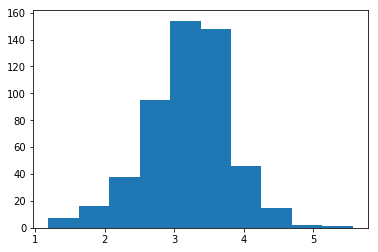

-1125.5753173828125
-1098.162109375
-1058.891845703125
-1095.3807373046875
-1105.9581298828125
-1063.5992431640625
-1046.37109375
-1118.72314453125
-1182.0325927734375
-1202.6368408203125


/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)(F)CCN1C(=O)NCc2cc(F)c(cc2C1=O)C1=NC(=O)c2c(SC(F)(F)F)nccc2-n2nc(C3CCC(=O)NC3=O)c2C1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1cc(F)cc(-c2nc(-c3ccc(F)cc3)n3ccnc4ccccc23)c1Cl
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1c(F)c(F)c(N2CC(N(c2cc2cc(C(F)(F)F)c3ccc(F)cc3)c3ccccc23)N(=O)=O)c(Cl)c1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: O=C(Nc1c(c-2c((-c3cc(F)c(F)c(F)c4-c3cccc-23)N2CCCC2)c2cncnc12)c1cccc(Cl)c1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanit

3.1998681602089416
0.428
0.8808411214953271


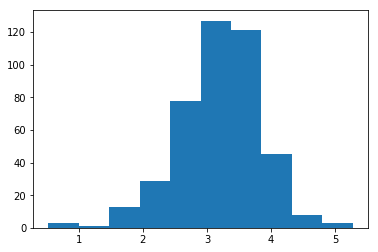

 29s (100 20%) 0.6056]
<Fc1ccc(-c2c(N2CCCN3CCCCC3)C(=S)N2c2ccccc2Cl)cc(c1)C(F)(F)F> 

 59s (200 40%) 0.6705]
<FCCN1CCC(C(C1)c1ccc(NC(=O)c2ccccc2)cc1-c1cc(C(F)(F)F)c(cc1NC1CCCN3CCNCC1)N3CC1CCCC1)N(=O)=O> 



In [ ]:
rewards = []

for _ in range(5):

    RL.transfer_learning(transfer_data, n_epochs=500)

    generated = []
    for _ in range(1000):
        generated.append(my_generator.evaluate(gen_data)[1:-1])

    sanitized = list(np.unique(sanitize_smiles(generated))[1:])
    smiles, prediction, nan_smiles = logp_predictor.predict(sanitized)

    print(prediction.mean())
    print(len(sanitized)/len(generated))
    print(len(np.where(prediction >= 2.5)[0])/len(prediction))
    plt.hist(prediction)
    plt.show()

    for i in np.where(prediction >=2.5)[0]:
        transfer_pool.append('<' + smiles[i] + '>')

    f = open('/home/mariewelt/Notebooks/PyTorch/data/transfer_data.smi', 'w')
    for sm in transfer_pool:
        f.writelines(sm + '\n')
    f.close()

    transfer_data.update_data('/home/mariewelt/Notebooks/PyTorch/data/transfer_data.smi')
    for i in range(len(transfer_data.file)):
        replay.push(transfer_data.file[i])

    for _ in range(20):
        rewards.append(RL.policy_gradient_replay(gen_data, replay, threshold=2.5))
        print(rewards[-1])

    generated = []
    for _ in range(1000):
        generated.append(my_generator.evaluate(gen_data)[1:-1])

    sanitized = list(np.unique(sanitize_smiles(generated))[1:])
    smiles, prediction, nan_smiles = logp_predictor.predict(sanitized)

    print(prediction.mean())
    print(len(sanitized)/len(generated))
    print(len(np.where(prediction >= 2.5)[0])/len(prediction))
    plt.hist(prediction)
    plt.show()

    for i in np.where(prediction >=2.5)[0]:
        transfer_pool.append(smiles[i])

    f = open('/home/mariewelt/Notebooks/PyTorch/data/transfer_data.smi', 'w')
    for sm in transfer_pool:
        f.writelines(sm + '\n')
    f.close()

    transfer_data.update_data('/home/mariewelt/Notebooks/PyTorch/data/transfer_data.smi')
    for i in range(len(transfer_data.file)):
        replay.push('<' + transfer_data.file[i] + '>')

    for _ in range(10):
        rewards.append(RL.policy_gradient(gen_data, threshold=2.5))
        print(rewards[-1]) 

    generated = []
    for _ in range(1000):
        generated.append(my_generator.evaluate(gen_data)[1:-1])

    sanitized = list(np.unique(sanitize_smiles(generated))[1:])
    smiles, prediction, nan_smiles = logp_predictor.predict(sanitized)

    print(prediction.mean())
    print(len(sanitized)/len(generated))
    print(len(np.where(prediction >= 2.5)[0])/len(prediction))
    plt.hist(prediction)
    plt.show()

    for i in np.where(prediction >=2.5)[0]:
        transfer_pool.append(smiles[i])

    f = open('/home/mariewelt/Notebooks/PyTorch/data/transfer_data.smi', 'w')
    for sm in transfer_pool:
        f.writelines(sm + '\n')
    f.close()

    transfer_data.update_data('/home/mariewelt/Notebooks/PyTorch/data/transfer_data.smi')
    for i in range(len(transfer_data.file)):
        replay.push('<' + transfer_data.file[i] + '>')

In [ ]:
generated = []
for _ in range(20000):
    generated.append(my_generator.evaluate(gen_data, predict_len=200)[1:-1])

/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: Fc1cc(c(F)c(F)c1Nc1nc(-c2cccc(N2CCN2CCCN(Cc3cc(C(F)(F)F)ccc3-c3ccccc3)C2)c(cc1F)N1CCNCC1)NC(=O)NC1C
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: O=C(N1CCCN(c2ccccc2)N=C(Nc2cc(-c3nc(-c4cc(F)c(F)cc4)cc-3c3ncn(-c4cnccc4)n3)C(=O)n2n1)c1ccccc1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: O=C(Nc1c(-c2ccc(C(=O)N3CCN(Cc4ccncc4)CC3)cc2)c2ccccc2-n2c(nc3cc(F)ccc23)c1O
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)CC1CCN(Cc2nc(-c3cccc(F)c3-c3ccc(-c4ccncc4)cc3F)N3CCOCC3)nc2n2CCC(CNc3ccc(F)cc3)CCn12
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/hom

/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)(F)c1ccc(COCC2CCN(c3nnc4ncccc34)N3CCCC3CN3CCn4cccc4C3=O)c2cc1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(c1c[nH]c2ccc(Nc3nc4ccc(Nc4c5c(Cl)ccnc5c45)ncc34)cc12)C1CCC2(CC(c3c2)c2ccc(O)cc23)C1
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)(F)c1ccc(C(=O)[N+]([O-])c2ccc(-c3ccc(nc3)N3CCN(Cc4ccccc4)CC3)N3CCN(Cc4c(cccc4[O-])S3(=O)=O)cc2
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mariewelt/Notebooks/PyTorch/DeNovo/data.py:160: UserWarning: Unsanitized SMILES string: FC(F)c1ccc(-c2ccc(-c3ccc(C(F)(F)F)cc3Cl)[nH]2)c(N1CCOCCOCCOc1ccc(-c2ccc(C(F)(F)F)cc2)c2ccccc12)C1CC
  warnings.warn('Unsanitized SMILES string: ' + sm, UserWarning)
/home/mari

3.2202697044043864
0.401
0.8653366583541147


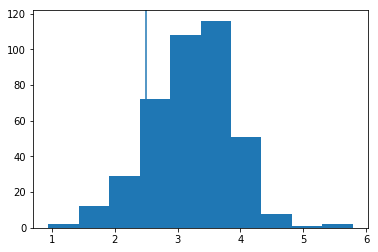

In [53]:
sanitized = list(np.unique(sanitize_smiles(generated))[1:])
smiles, prediction, nan_smiles = logp_predictor.predict(sanitized)

3.2202697044043864
0.401
0.8653366583541147


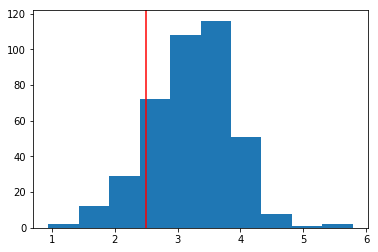

In [54]:
print(prediction.mean())
print(len(sanitized)/len(generated))
print(len(np.where(prediction >= 2.5)[0])/len(prediction))
plt.hist(prediction)
plt.axvline(x=2.5, color='red')
plt.show()

In [57]:
generated_mols = [Chem.MolFromSmiles(sm) for sm in smiles]
generated_fps = [FingerprintMols.FingerprintMol(x) for x in generated_mols]

In [58]:
logp_mols = [Chem.MolFromSmiles(sm) for sm in logp_data.smiles]
logp_fps = [FingerprintMols.FingerprintMol(x) for x in logp_mols]

In [60]:
sim = []
sim_smiles = []
sim_labels = []
for fp1 in generated_fps:
    max_sim = 0.0
    for j in range(len(logp_fps)):
        fp2 = logp_fps[j]
        tmp = DataStructs.FingerprintSimilarity(fp1,fp2)
        if tmp > max_sim:
            max_sim = tmp
            tmp_sm = logp_data.smiles[j]
            tmp_label = logp_data.property[j]
    sim.append(max_sim)
    sim_smiles.append(tmp_sm)
    sim_labels.append(tmp_label)

(array([222.,  63.,  33.,  28.,  22.,  12.,   9.,   8.,   2.,   2.]),
 array([0.546875  , 0.58149074, 0.61610648, 0.65072222, 0.68533795,
        0.71995369, 0.75456943, 0.78918517, 0.82380091, 0.85841665,
        0.89303238]),
 <a list of 10 Patch objects>)

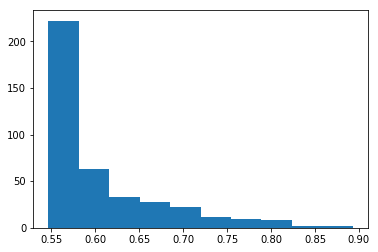

In [63]:
plt.hist(sim)